In [1]:
import json
import os
import random

from bnbprob.pafssp import (
    CallbackBnB,
    PermFlowShop,
    plot_gantt,
)
from bnbprob.pafssp.instances import AssemblyFlowShopInstance
from bnbpy import configure_logfile

In [2]:
configure_logfile("complex-layouts.log")

In [3]:
file = 'custom-028-50-chain7.json'
input_path = './../data/pafssp/custom-chain'

name = file[:-5]
with open(os.path.join(input_path, file), 'r', encoding='utf8') as f:
    data = json.load(f)
instance = AssemblyFlowShopInstance(data["p"], data["edges"])

In [4]:
problem = PermFlowShop.from_p(
    instance.p, edges=instance.edges, constructive='iga'
)
bnb = CallbackBnB()

In [5]:
print(problem.lower_bound_1m())
print(problem.lower_bound_2m())

2966
2966


In [13]:
problem.get_mach_graph()

MachineGraph(M=17, prec=[[], [0, 7], [1], [2, 10], [3], [4], [5, 16], [], [], [8], [9], [], [11], [12], [13], [14], [15]], succ=[[1], [2], [3], [4], [5], [6], [], [1], [9], [10], [3], [12], [13], [14], [15], [16], [6]], topo_order=[0, 7, 8, 11, 1, 9, 12, 2, 10, 13, 3, 14, 4, 15, 5, 16, 6], rev_topo_order=[6, 16, 5, 15, 4, 14, 3, 13, 10, 2, 12, 9, 1, 11, 8, 7, 0], descendants=[[1, 2, 3, 4, 5, 6], [2, 3, 4, 5, 6], [3, 4, 5, 6], [4, 5, 6], [5, 6], [6], [], [1, 2, 3, 4, 5, 6], [3, 4, 5, 6, 9, 10], [3, 4, 5, 6, 10], [3, 4, 5, 6], [6, 12, 13, 14, 15, 16], [6, 13, 14, 15, 16], [16, 6, 14, 15], [16, 6, 15], [16, 6], [6]])

In [7]:
import pandas as pd

In [12]:
df = pd.read_csv("dpm-opt-experiments.csv", index_col=False)

In [13]:
df.columns

Index(['name', 'warmstart', 'lb1_start', 'lb5_start', 'incumbent',
       'lower_bound', 'execution_time', 'gap', 'nodes', 'sequence'],
      dtype='object')

In [14]:
(df["lb1_start"] > df["lb5_start"]).sum()

np.int64(0)

In [17]:
def create_chain_edges(n_chain: int) -> tuple[list[tuple[int, int]], int]:
    """
    Create edges for a complex digraph with multiple chains merging into a main chain.

    Parameters
    ----------
    n_chain : int
        Number of nodes in the main chain (must be >= 2)

    Returns
    -------
    edges : list[tuple[int, int]]
        List of directed edges
    M : int
        Total number of machines/nodes

    Structure:
    - Main chain: 0 -> 1 -> 2 -> ... -> (n_chain - 1)
    - Second chain: starts at node n_chain, connects to node 1,
      then continues with (n_chain // 2 - 1) more nodes and merges at node (n_chain // 2)
    - Third chain: has (n_chain - 1) nodes and merges at node (n_chain - 1)
    """
    if n_chain < 2:
        raise ValueError("n_chain must be at least 2")

    edges = []

    # Main chain: 0 -> 1 -> 2 -> ... -> (n_chain - 1)
    for i in range(n_chain - 1):
        edges.append((i, i + 1))

    current_node = n_chain

    # Second chain: connects to node 1, then merges at position (n_chain // 2)
    merge_pos_2 = n_chain // 2
    chain_2_length = merge_pos_2

    if chain_2_length > 0:
        # First node of chain 2 connects to node 1 of main chain
        edges.append((current_node, 1))
        current_node += 1

        # Create remaining nodes of chain 2
        for _ in range(chain_2_length - 1):
            edges.append((current_node, current_node + 1))
            current_node += 1
        # Connect last node of chain 2 to merge position in main chain
        edges.append((current_node, merge_pos_2))
        current_node += 1

    # Third chain merging at position (n_chain - 1)
    merge_pos_3 = n_chain - 1
    chain_3_length = merge_pos_3

    if chain_3_length > 0:
        # Create third chain nodes
        for _ in range(chain_3_length - 1):
            edges.append((current_node, current_node + 1))
            current_node += 1
        # Connect last node of chain 3 to merge position in main chain
        edges.append((current_node, merge_pos_3))
        current_node += 1

    M = current_node  # Total number of nodes

    return edges, M


# Example: n_chain = 5
N = 20
n_chain = 5
edges, M = create_chain_edges(n_chain)

print(f"n_chain = {n_chain}")
print(f"Total machines M = {M}")
print(f"Edges: {edges}")

random.seed(42)
p = [[random.randint(1, 100) for _ in range(M)] for _ in range(N)]

n_chain = 5
Total machines M = 12
Edges: [(0, 1), (1, 2), (2, 3), (3, 4), (5, 1), (6, 7), (7, 2), (8, 9), (9, 10), (10, 11), (11, 4)]


In [18]:
problem = PermFlowShop.from_p(p, edges)
bnb = CallbackBnB()

res = bnb.solve(problem)

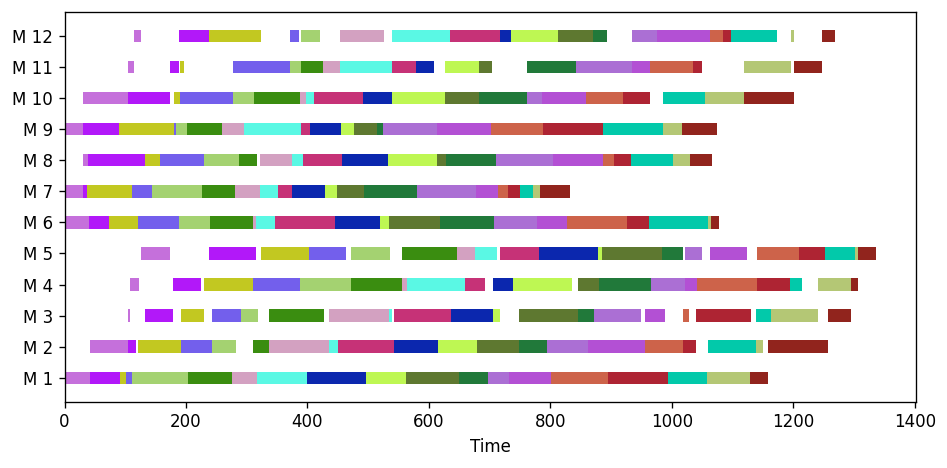

In [19]:
plot_gantt(res.problem.sequence, dpi=120, seed=42, figsize=[8, 4])